In [1]:
%load_ext autoreload
%autoreload 1
%aimport helpers, loaders, plotters

In [2]:
# This helps with joblib "No space left on device" errors
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [3]:
from pprint import pprint
from math import ceil, floor
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from helpers import balanced_accuracy_scorer, balanced_accuracy, load_best_search, load_best_learning, save_learning_curve, save_search_result, scikit_cv_result_to_df
from loaders import load_adult, load_mnist
from plotters import plot_means_w_stds, gen_and_plot_learning_curve, plot_learning_curve, gen_and_plot_validation_curve, plot_validation_curve

### Load Data

In [4]:
dataset = 'adult'
learner_type = 'ANN'
loader_func = load_adult

In [5]:
df = loader_func(preprocess=True)

Dataset shape (30162, 105)
Value composition:
0    0.751078
1    0.248922
Name: target, dtype: float64


### Split data into training and testing

In [6]:
from sklearn.model_selection import train_test_split

X = df[[c for c in df.columns if c != 'target']]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Scale Data

In [7]:
# Use min max scaling because input dataset is sparse, i.e. mostly zeros
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Neural Nets

In [8]:
# Build a KerasClassifier for use with scikit-learn
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier


n_features = X_train.shape[1]


def build_keras_clf(hidden_layer_sizes=(10,10), learning_rate_init=0.01, momentum=0.8):
    """This function builds a Keras model for use with scikit's GridSearch"""
    if not isinstance(hidden_layer_sizes, tuple):
        hidden_layer_sizes = (hidden_layer_sizes,)
    
    model = Sequential()
    
    model.add(Dense(units=n_features, input_shape=(n_features,), activation='relu'))
    
    for layer_size in hidden_layer_sizes:
        assert layer_size > 0
        model.add(Dense(units=layer_size, activation='relu'))
    
    # Add output layer
    model.add(Dense(units=1, activation='sigmoid'))
        
    sgd = SGD(lr=learning_rate_init, momentum=momentum, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["accuracy"])
    
    return model

clf = KerasClassifier(build_fn=build_keras_clf, verbose=0)

Using TensorFlow backend.


### GridSearch for model complexity curves

In [9]:
layer_sizes = [
    (10,10),
#     (50,50),
    (100,100),
]

param_grid = {
    'hidden_layer_sizes': layer_sizes,
#     'learning_rate_init': [0.01, .1, .2],
#     'momentum': [0.7, 0.8, 0.9],
    'epochs': [1, 10, 100, 200]
}

In [12]:
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=balanced_accuracy_scorer,
    return_train_score=True,
    cv=4,
    verbose=10,
    n_jobs=1,
)

In [13]:
grid_search.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] epochs=1, hidden_layer_sizes=(10, 10) ...........................
[CV]  epochs=1, hidden_layer_sizes=(10, 10), score=0.5788861793818969, total=   1.0s
[CV] epochs=1, hidden_layer_sizes=(10, 10) ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  epochs=1, hidden_layer_sizes=(10, 10), score=0.6820156673233193, total=   1.0s
[CV] epochs=1, hidden_layer_sizes=(10, 10) ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV]  epochs=1, hidden_layer_sizes=(10, 10), score=0.718005119180931, total=   0.9s
[CV] epochs=1, hidden_layer_sizes=(10, 10) ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s


[CV]  epochs=1, hidden_layer_sizes=(10, 10), score=0.6964642500356788, total=   0.9s
[CV] epochs=1, hidden_layer_sizes=(100, 100) .........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s


[CV]  epochs=1, hidden_layer_sizes=(100, 100), score=0.7295731163742506, total=   1.1s
[CV] epochs=1, hidden_layer_sizes=(100, 100) .........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.0s remaining:    0.0s


[CV]  epochs=1, hidden_layer_sizes=(100, 100), score=0.6910792061684313, total=   1.1s
[CV] epochs=1, hidden_layer_sizes=(100, 100) .........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.3s remaining:    0.0s


[CV]  epochs=1, hidden_layer_sizes=(100, 100), score=0.6881845571375247, total=   1.0s
[CV] epochs=1, hidden_layer_sizes=(100, 100) .........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.6s remaining:    0.0s


[CV]  epochs=1, hidden_layer_sizes=(100, 100), score=0.696232339089482, total=   1.2s
[CV] epochs=10, hidden_layer_sizes=(10, 10) ..........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   10.1s remaining:    0.0s


[CV]  epochs=10, hidden_layer_sizes=(10, 10), score=0.7315441754579486, total=   6.0s
[CV] epochs=10, hidden_layer_sizes=(10, 10) ..........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.3s remaining:    0.0s


[CV]  epochs=10, hidden_layer_sizes=(10, 10), score=0.7735531196133958, total=   6.3s
[CV] epochs=10, hidden_layer_sizes=(10, 10) ..........................
[CV]  epochs=10, hidden_layer_sizes=(10, 10), score=0.7470364741641338, total=   7.3s
[CV] epochs=10, hidden_layer_sizes=(10, 10) ..........................
[CV]  epochs=10, hidden_layer_sizes=(10, 10), score=0.7138932496075354, total=   7.1s
[CV] epochs=10, hidden_layer_sizes=(100, 100) ........................
[CV]  epochs=10, hidden_layer_sizes=(100, 100), score=0.7751378170416551, total=   8.0s
[CV] epochs=10, hidden_layer_sizes=(100, 100) ........................
[CV]  epochs=10, hidden_layer_sizes=(100, 100), score=0.7647087001354347, total=  40.5s
[CV] epochs=10, hidden_layer_sizes=(100, 100) ........................


/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.782660). Check your callbacks.
  % delta_t_median)
/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.755281). Check your callbacks.
  % delta_t_median)
/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (1.720750). Check your callbacks.
  % delta_t_median)


[CV]  epochs=10, hidden_layer_sizes=(100, 100), score=0.7536247533727938, total=17.5min
[CV] epochs=10, hidden_layer_sizes=(100, 100) ........................
[CV]  epochs=10, hidden_layer_sizes=(100, 100), score=0.7712822891394321, total=   8.6s
[CV] epochs=100, hidden_layer_sizes=(10, 10) .........................
[CV]  epochs=100, hidden_layer_sizes=(10, 10), score=0.7483017738017592, total= 1.1min
[CV] epochs=100, hidden_layer_sizes=(10, 10) .........................
[CV]  epochs=100, hidden_layer_sizes=(10, 10), score=0.7671101637527702, total= 1.0min
[CV] epochs=100, hidden_layer_sizes=(10, 10) .........................
[CV]  epochs=100, hidden_layer_sizes=(10, 10), score=0.7598890844131606, total=  58.8s
[CV] epochs=100, hidden_layer_sizes=(10, 10) .........................
[CV]  epochs=100, hidden_layer_sizes=(10, 10), score=0.7589374910803484, total= 1.0min
[CV] epochs=100, hidden_layer_sizes=(100, 100) .......................
[CV]  epochs=100, hidden_layer_sizes=(100, 100), s

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 49.1min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f92aa23a908>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(10, 10), (100, 100)], 'epochs': [1, 10, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(balanced_accuracy), verbose=10)

In [14]:
save_search_result(grid_search, dataset, learner_type)

### Model Complexity Analysis

In [10]:
# res = grid_search.cv_results_
res = load_best_search(dataset, learner_type)
res_df = scikit_cv_result_to_df(res)
res_df.sort_values(by='rank_test_score').head(10)

Found the following results files for this dataset/algorithm: ['search_adult_ANN_0.780_2018-09-23_11-53-04-00_.pkl']
Returning results for the highest-scoring-file: search_adult_ANN_0.780_2018-09-23_11-53-04-00_.pkl


mean_fit_time  std_fit_time  mean_score_time  \
epochs hidden_layer_sizes                                                 
100    (100, 100)              74.980723      5.018189         0.287097   
200    (100, 100)             165.744577      2.918580         0.359957   
10     (100, 100)             277.208397    447.861804         0.288694   
100    (10, 10)                62.178848      2.588051         0.243694   
200    (10, 10)               144.417670      3.435120         0.309279   
10     (10, 10)                 6.492168      0.520232         0.161801   
1      (100, 100)               0.986765      0.066950         0.129558   
       (10, 10)                 0.855574      0.059733         0.087484   

                           std_score_time  mean_test_score  std_test_score  \
epochs hidden_layer_sizes                                                    
100    (100, 100)                0.012063         0.779955        0.019702   
200    (100, 100)                0.003494         0.769455        0.009876   
10     (100, 100)                0.055926         0.766189        0.008156   
100    (10, 10)                  0.006699         0.758559        0.006713   
200    (10, 10)                  0.010197         0.749236        0.018327   
10     (10, 10)                  0.016384         0.741506        0.021905   
1      (100, 100)                0.010902         0.701269        0.016595   
       (10, 10)                  0.003001         0.668839        0.053494   

                           rank_test_score  mean_train_score  std_train_score  
epochs hidden_layer_sizes                                                      
100    (100, 100)                        1          0.840375         0.017100  
200    (100, 100)                        2          0.862676         0.010311  
10     (100, 100)                        3          0.771785         0.010613  
100    (10, 10)                          4          0.815568         0.010003  
200    (10, 10)                          5          0.836488         0.019741  
10     (10, 10)                          6          0.745846         0.024902  
1      (100, 100)                        7          0.698600         0.012981  
       (10, 10)                          8          0.672469         0.057371

In [16]:
small_network = res_df.xs((10,10), level='hidden_layer_sizes')
large_network = res_df.xs((100,100), level='hidden_layer_sizes')

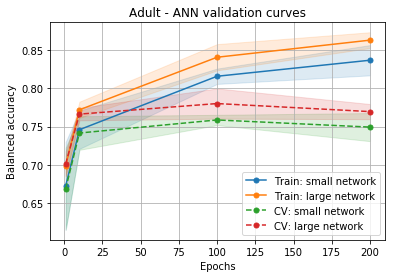

In [29]:
# Plot combined validation curve
plot_means_w_stds(
    means=(small_network['mean_train_score'], large_network['mean_train_score'], small_network['mean_test_score'], large_network['mean_test_score']),
    stds=(small_network['std_train_score'], large_network['std_train_score'], small_network['std_test_score'], large_network['std_test_score']),
    xrange=param_grid['epochs'],
    xlabel='Epochs',
    ylabel='Balanced accuracy',
    series_labels=('Train: small network', 'Train: large network', 'CV: small network', 'CV: large network'),
    title='Adult - ANN validation curves',
    legend_kwargs={'loc': 'best'}
)

### Timing analysis

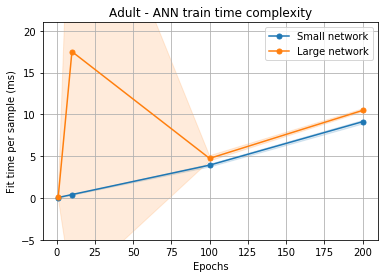

In [19]:
means = [small_network['mean_fit_time'], large_network['mean_fit_time']]
stds = [small_network['std_fit_time'], large_network['std_fit_time']]
labels = ['Small network', 'Large network']

# Calculate per-sample mean
n_samples = X_train_scaled.shape[0] * 3/4 # three-quarters of dataset was fit for 4-fold validation
# convert to milliseconds
means_per_samp = [mean / n_samples * 1000 for mean in means]
stds_per_samp = [std / n_samples * 1000 for std in stds]

plot_means_w_stds(
    means_per_samp,
    stds_per_samp,
    param_grid['epochs'],
    series_labels=labels,
    title='Adult - ANN train time complexity',
    legend_kwargs={'loc': 'best'},
    ylabel='Fit time per sample (ms)',
    xlabel='Epochs',
    linestyles=['-']*2,
    ylim=[-5, 21]
#     fig_kwargs={'figsize': (10,6)},
)

## Learning Curves for best learner

### What is the best learner?

In [11]:
best_params = res['params'][np.argmax(res['mean_test_score'])]
clf = KerasClassifier(build_fn=build_keras_clf, verbose=0, **best_params)
clf.get_params()

{'verbose': 0,
 'epochs': 100,
 'hidden_layer_sizes': (100, 100),
 'build_fn': <function __main__.build_keras_clf(hidden_layer_sizes=(10, 10), learning_rate_init=0.01, momentum=0.8)>}

[learning_curve] Training set sizes: [ 1583  3166  4750  6333  7917  9500 11083 12667 14250 15834]


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 28.5min finished


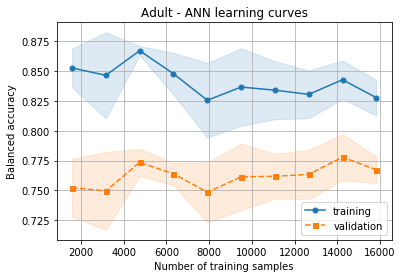

In [12]:
train_sizes, train_mean, train_std, test_mean, test_std = gen_and_plot_learning_curve(clf, X_train_scaled, y_train, ylim=None, cv=4, scoring=balanced_accuracy_scorer, ylabel='Balanced accuracy', title='Adult - ANN learning curves', verbose=1)

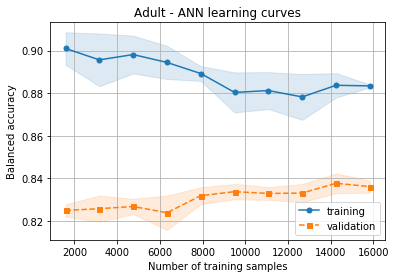

In [28]:
plot_learning_curve(train_sizes, train_mean, train_std, test_mean, test_std, ylabel='Balanced accuracy', title='Adult - ANN learning curves')

In [24]:
save_learning_curve(dataset, learner_type, train_sizes, train_mean, train_std, test_mean, test_std)

# Test Set Performance

In [26]:
best_clf = KerasClassifier(build_fn=build_keras_clf, verbose=0, **best_params)

best_clf.fit(X_train_scaled, y_train)
y_test_pred = best_clf.predict(X_test_scaled)
test_score = balanced_accuracy(y_test, y_test_pred)

In [27]:
print('%.4f' % test_score)

0.7706
